<a href="https://colab.research.google.com/github/hcao2015/driver_schedule_optimization/blob/main/Satellite_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline


In [2]:
import tifffile as tiff
import matplotlib as mpl
from matplotlib import pyplot as plt 
mpl.rcParams['figure.figsize'] = (10,10)  # plot sizes


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Establish working directory
import os # Operation System
os.getcwd()
%cd /content/gdrive/My Drive/
!pwd
!ls
print('Working Directory')
print(os.getcwd())

[Errno 2] No such file or directory: '/content/gdrive/My Drive/'
/content
/content
drive	      model.png   sample_data	    weights100
log_unet.csv  oldweights  tensorboard_unet
Working Directory
/content


In [5]:
# Load Data 
work_dir = "/content/drive/My Drive"


In [6]:
id = '22'
img = tiff.imread(work_dir+'/data/mband/{}.tif'.format(id))
print(type(img))
print(img.dtype)
print(img.shape)



<class 'numpy.ndarray'>
uint16
(8, 837, 849)


(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f33a27c1e10>)

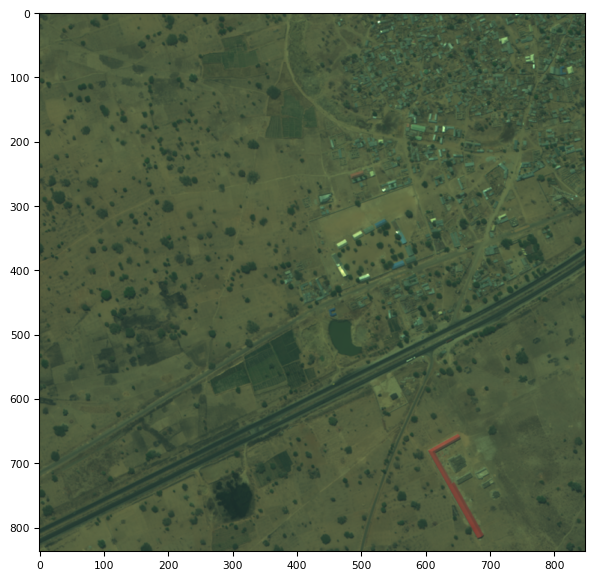

In [21]:
rgb_img = img[(4,2,1),:,:]
tiff.imshow(rgb_img)



In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose,BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, ReduceLROnPlateau, EarlyStopping

import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np

import gc
import math
import random
import time
import os
import graphviz
import pydot

In [16]:
# constants


DATA_PATH_PREFIX = work_dir+'/data/'


N_BANDS = 8    # input channel shape
N_CLASSES = 5  # buildings, roads, trees, crops and water
CLASS_WEIGHTS = [0.2, 0.3, 0.1, 0.1, 0.3]

UPCONV = True    # True to use Up-Convolutuin (=TransposedConvolution), False to use Up-Sampling
PATCH_SZ = 160   # should divide by 16

N_EPOCHS = 100
#BATCH_SIZE = 256
BATCH_SIZE = 32

TRAIN_SZ = 4*BATCH_SIZE  # train size (for one epoch)
VAL_SZ = 1024    # validation size

In [32]:
#Implementation of deep U-Net 
def unet_model(n_classes=N_CLASSES, im_sz=PATCH_SZ, n_channels=N_BANDS, n_filters_start=32, growth_factor=2, upconv=True,
               class_weights=CLASS_WEIGHTS):
  
    droprate=0.25
    n_filters = n_filters_start
    inputs = Input((im_sz, im_sz, n_channels))
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(droprate)(pool1)
    
    
    n_filters *= growth_factor
    poolX = BatchNormalization()(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(poolX)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(droprate)(pool2)

    n_filters *= growth_factor
    pool2 = BatchNormalization()(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(droprate)(pool3)

    n_filters *= growth_factor
    pool3 = BatchNormalization()(pool3)
    conv4 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    # pool4 = Dropout(droprate)(pool4)

    n_filters *= growth_factor
    pool4 = BatchNormalization()(pool4)
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Dropout(droprate)(conv5)

    n_filters //= growth_factor
    if upconv:
        up6 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv5), conv4])
    else:
        up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4])
    up6 = BatchNormalization()(up6)
    conv6 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = Dropout(droprate)(conv6)

    n_filters //= growth_factor
    if upconv:
        up7 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6), conv3])
    else:
        up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3])
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(droprate)(conv7)

    n_filters //= growth_factor
    if upconv:
        up8 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    else:
        up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(droprate)(conv8)

    n_filters //= growth_factor
    if upconv:
        up9 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    else:
        up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    up9 = BatchNormalization()(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    def weighted_binary_crossentropy(y_true, y_pred):
        class_loglosses = K.mean(K.binary_crossentropy(y_true, y_pred), axis=[0, 1, 2])
        return K.sum(class_loglosses * K.constant(class_weights))

    model.compile(optimizer=Adam(), loss=weighted_binary_crossentropy)
    return model


if __name__ == '__main__':
    model = unet_model()
    print(model.summary())
    plot_model(model, show_shapes=True)

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 160, 160, 8  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_285 (Conv2D)            (None, 160, 160, 32  2336        ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_286 (Conv2D)            (None, 160, 160, 32  9248        ['conv2d_285[0][0]']             
                                )                                                          

In [10]:
#Alternative of Unet
#Implementation of deep U-Net 
# def unet_model(n_classes=5, im_sz=160, n_channels=8, n_filters_start=32, growth_factor=2, upconv=True,
#                class_weights=[0.2, 0.3, 0.1, 0.1, 0.3]):
#     n_filters = n_filters_start
#     inputs = Input((im_sz, im_sz, n_channels))
#     conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     n_filters *= growth_factor
#     conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     n_filters *= growth_factor
#     conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     n_filters *= growth_factor
#     conv4 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool3)
#     conv4 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

#     n_filters *= growth_factor
#     conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4)
#     conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv5)

#     n_filters //= growth_factor
#     if upconv:
#         up6 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv5), conv4])
#     else:
#         up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4])
#     conv6 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6)
#     conv6 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6)

#     n_filters //= growth_factor
#     if upconv:
#         up7 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6), conv3])
#     else:
#         up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3])
#     conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up7)
#     conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv7)

#     n_filters //= growth_factor
#     if upconv:
#         up8 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
#     else:
#         up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
#     conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up8)
#     conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv8)

#     n_filters //= growth_factor
#     if upconv:
#         up9 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
#     else:
#         up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
#     conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up9)
#     conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv9)

#     conv10 = Conv2D(n_classes, (1, 1), activation='sigmoid')(conv9)

#     model = Model(inputs=inputs, outputs=conv10)

#     def weighted_binary_crossentropy(y_true, y_pred):
#         class_loglosses = K.mean(K.binary_crossentropy(y_true, y_pred), axis=[0, 1, 2])
#         return K.sum(class_loglosses * K.constant(class_weights))

#     model.compile(optimizer=Adam(), loss=weighted_binary_crossentropy)
#     return model


# if __name__ == '__main__':
#     model = unet_model()
#     print(model.summary())
#     plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 8  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 32  2336        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 160, 160, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [18]:
#Normalize image 
def normalize(img):
    min = img.min()
    max = img.max()
    return 2.0 * (img - min) / (max - min) - 1.0


In [19]:
import random
import numpy as np


def get_rand_patch(img, mask, sz=PATCH_SZ):
    """
    :param img: ndarray with shape (x_sz, y_sz, num_channels)
    :param mask: binary ndarray with shape (x_sz, y_sz, num_classes)
    :param sz: size of random patch
    :return: patch with shape (sz, sz, num_channels)
    """
    assert len(img.shape) == 3 and img.shape[0] > sz and img.shape[1] > sz and img.shape[0:2] == mask.shape[0:2]
    xc = random.randint(0, img.shape[0] - sz)
    yc = random.randint(0, img.shape[1] - sz)
    patch_img = img[xc:(xc + sz), yc:(yc + sz)]
    patch_mask = mask[xc:(xc + sz), yc:(yc + sz)]
    return patch_img, patch_mask


def get_patches(x_dict, y_dict, n_patches, sz=PATCH_SZ):
    x = list()
    y = list()
    total_patches = 0
    while total_patches < n_patches:
        img_id = random.sample(x_dict.keys(), 1)[0]
        img = x_dict[img_id]
        mask = y_dict[img_id]
        img_patch, mask_patch = get_rand_patch(img, mask, sz)
        x.append(img_patch)
        y.append(mask_patch)
        total_patches += 1
    print('Generated {} patches'.format(total_patches))
    return np.array(x), np.array(y)

In [12]:
#Alternative 

# import random
# import numpy as np


# def get_rand_patch(img, mask, sz=PATCH_SZ):
#     """
#     :param img: ndarray with shape (x_sz, y_sz, num_channels)
#     :param mask: binary ndarray with shape (x_sz, y_sz, num_classes)
#     :param sz: size of random patch
#     :return: patch with shape (sz, sz, num_channels)
#     """
#     assert len(img.shape) == 3 and img.shape[0] > sz and img.shape[1] > sz and img.shape[0:2] == mask.shape[0:2]
#     xc = random.randint(0, img.shape[0] - sz)
#     yc = random.randint(0, img.shape[1] - sz)
#     patch_img = img[xc:(xc + sz), yc:(yc + sz)]
#     patch_mask = mask[xc:(xc + sz), yc:(yc + sz)]

#    # Apply some random transformations
#     random_transformation = np.random.randint(1,8)
#     if random_transformation == 1:  # reverse first dimension
#         patch_img = patch_img[::-1,:,:]
#         patch_mask = patch_mask[::-1,:,:]
#     elif random_transformation == 2:    # reverse second dimension
#         patch_img = patch_img[:,::-1,:]
#         patch_mask = patch_mask[:,::-1,:]
#     elif random_transformation == 3:    # transpose(interchange) first and second dimensions
#         patch_img = patch_img.transpose([1,0,2])
#         patch_mask = patch_mask.transpose([1,0,2])
#     elif random_transformation == 4:
#         patch_img = np.rot90(patch_img, 1)
#         patch_mask = np.rot90(patch_mask, 1)
#     elif random_transformation == 5:
#         patch_img = np.rot90(patch_img, 2)
#         patch_mask = np.rot90(patch_mask, 2)
#     else:
#         patch_img = np.rot90(patch_img, 3)
#         patch_mask = np.rot90(patch_mask, 3)
#     # else:
#     #     pass



#     return patch_img, patch_mask


# def get_patches(x_dict, y_dict, n_patches, sz=PATCH_SZ):
#     x = list()
#     y = list()
#     total_patches = 0
#     while total_patches < n_patches:
#         img_id = random.sample(x_dict.keys(), 1)[0]
#         img = x_dict[img_id]
#         mask = y_dict[img_id]
#         img_patch, mask_patch = get_rand_patch(img, mask, sz)
#         x.append(img_patch)
#         y.append(mask_patch)
#         total_patches += 1
#     print('Generated {} patches'.format(total_patches))
#     return np.array(x), np.array(y)



In [33]:


import os.path
import numpy as np
import tifffile as tiff
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint




N_BANDS = 8
N_CLASSES = 5  # buildings, roads, trees, crops and water

CLASS_WEIGHTS = [0.2, 0.3, 0.1, 0.1, 0.3]

N_EPOCHS = 30
UPCONV = True
#PATCH_SZ = 160   # should divide by 16
#BATCH_SIZE = 100
TRAIN_SZ = 4000  # train size
VAL_SZ = 1000    # validation size


def get_model():
    return unet_model(N_CLASSES, PATCH_SZ, n_channels=N_BANDS, upconv=UPCONV, class_weights=CLASS_WEIGHTS)


weights_path = 'weights'
if not os.path.exists(weights_path):
    os.makedirs(weights_path)
weights_path += '/unet_weights.hdf5'

trainIds = [str(i).zfill(2) for i in range(1, 25)]  # all availiable ids: from "01" to "24"


if __name__ == '__main__':
    X_DICT_TRAIN = dict()
    Y_DICT_TRAIN = dict()
    X_DICT_VALIDATION = dict()
    Y_DICT_VALIDATION = dict()

    print('Reading images')
    for img_id in trainIds:
        img_m = normalize(tiff.imread(f'{DATA_PATH_PREFIX}/mband/{img_id}.tif').transpose([1, 2, 0]))
        mask = tiff.imread(f'{DATA_PATH_PREFIX}/gt_mband/{img_id}.tif').transpose([1, 2, 0]) / 255
        train_xsz = int(3/4 * img_m.shape[0])  # use 75% of image as train and 25% for validation
        X_DICT_TRAIN[img_id] = img_m[:train_xsz, :, :]
        Y_DICT_TRAIN[img_id] = mask[:train_xsz, :, :]
        X_DICT_VALIDATION[img_id] = img_m[train_xsz:, :, :]
        Y_DICT_VALIDATION[img_id] = mask[train_xsz:, :, :]
        print(img_id + ' read')
    print('Images were read')

    def train_net():
        print("start train net")
        x_train, y_train = get_patches(X_DICT_TRAIN, Y_DICT_TRAIN, n_patches=TRAIN_SZ, sz=PATCH_SZ)
        x_val, y_val = get_patches(X_DICT_VALIDATION, Y_DICT_VALIDATION, n_patches=VAL_SZ, sz=PATCH_SZ)
        model = get_model()
        if os.path.isfile(weights_path):
            model.load_weights(weights_path)
        model_checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True)
        csv_logger = CSVLogger('log_unet.csv', append=True, separator=';')
        tensorboard = TensorBoard(log_dir='./tensorboard_unet/', write_graph=True, write_images=True)
        earlyStop = EarlyStopping(patience=5, verbose=1)
        model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS,
                  verbose=2, shuffle=True,
                  callbacks=[model_checkpoint, csv_logger, tensorboard],
                  validation_data=(x_val, y_val))
        return model

    train_net()


Reading images
01 read
02 read
03 read
04 read
05 read
06 read
07 read
08 read
09 read
10 read
11 read
12 read
13 read
14 read
15 read
16 read
17 read
18 read
19 read
20 read
21 read
22 read
23 read
24 read
Images were read
start train net
Generated 4000 patches
Generated 1000 patches
Epoch 1/30
125/125 - 23s - loss: 0.1642 - val_loss: 0.2048 - 23s/epoch - 186ms/step
Epoch 2/30
125/125 - 19s - loss: 0.1172 - val_loss: 0.1705 - 19s/epoch - 152ms/step
Epoch 3/30
125/125 - 19s - loss: 0.1085 - val_loss: 0.1599 - 19s/epoch - 152ms/step
Epoch 4/30
125/125 - 19s - loss: 0.1025 - val_loss: 0.1760 - 19s/epoch - 150ms/step
Epoch 5/30
125/125 - 19s - loss: 0.1021 - val_loss: 0.3122 - 19s/epoch - 149ms/step
Epoch 6/30
125/125 - 19s - loss: 0.0961 - val_loss: 0.1154 - 19s/epoch - 152ms/step
Epoch 7/30
125/125 - 19s - loss: 0.0902 - val_loss: 0.1426 - 19s/epoch - 149ms/step
Epoch 8/30
125/125 - 19s - loss: 0.0876 - val_loss: 0.1049 - 19s/epoch - 152ms/step
Epoch 9/30
125/125 - 19s - loss: 0.0840 - 

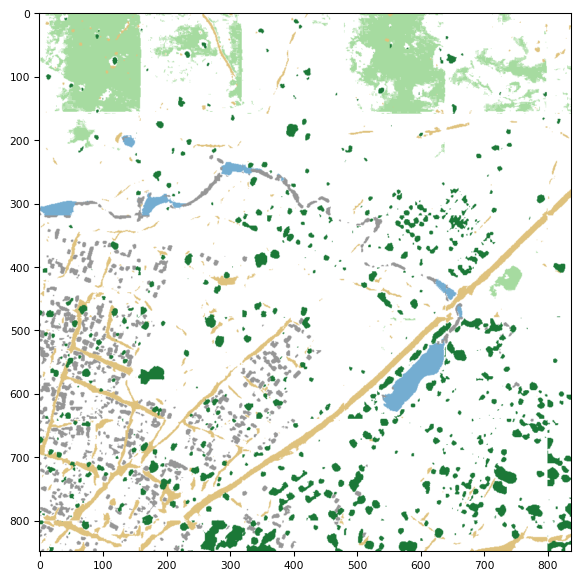

In [34]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

#from train_unet import weights_path, get_model, normalize, PATCH_SZ, N_CLASSES


def predict(x, model, patch_sz=PATCH_SZ, n_classes=N_CLASSES):
    img_height = x.shape[0]
    img_width = x.shape[1]
    n_channels = x.shape[2]
    # make extended img so that it contains integer number of patches
    npatches_vertical = math.ceil(img_height / patch_sz)
    npatches_horizontal = math.ceil(img_width / patch_sz)
    extended_height = patch_sz * npatches_vertical
    extended_width = patch_sz * npatches_horizontal
    ext_x = np.zeros(shape=(extended_height, extended_width, n_channels), dtype=np.float32)
    # fill extended image with mirrors:
    ext_x[:img_height, :img_width, :] = x
    for i in range(img_height, extended_height):
        ext_x[i, :, :] = ext_x[2 * img_height - i - 1, :, :]
    for j in range(img_width, extended_width):
        ext_x[:, j, :] = ext_x[:, 2 * img_width - j - 1, :]

    # now we assemble all patches in one array
    patches_list = []
    for i in range(0, npatches_vertical):
        for j in range(0, npatches_horizontal):
            x0, x1 = i * patch_sz, (i + 1) * patch_sz
            y0, y1 = j * patch_sz, (j + 1) * patch_sz
            patches_list.append(ext_x[x0:x1, y0:y1, :])
    # model.predict() needs numpy array rather than a list
    patches_array = np.asarray(patches_list)
    # predictions:
    patches_predict = model.predict(patches_array, batch_size=4)
    prediction = np.zeros(shape=(extended_height, extended_width, n_classes), dtype=np.float32)
    for k in range(patches_predict.shape[0]):
        i = k // npatches_horizontal
        j = k % npatches_vertical
        x0, x1 = i * patch_sz, (i + 1) * patch_sz
        y0, y1 = j * patch_sz, (j + 1) * patch_sz
        prediction[x0:x1, y0:y1, :] = patches_predict[k, :, :, :]
    return prediction[:img_height, :img_width, :]


def picture_from_mask(mask, threshold=0):
    colors = {
        0: [150, 150, 150],  # Buildings
        1: [223, 194, 125],  # Roads & Tracks
        2: [27, 120, 55],    # Trees
        3: [166, 219, 160],  # Crops
        4: [116, 173, 209]   # Water
    }
    z_order = {
        1: 3,
        2: 4,
        3: 0,
        4: 1,
        5: 2
    }
    pict = 255*np.ones(shape=(3, mask.shape[1], mask.shape[2]), dtype=np.uint8)
    for i in range(1, 6):
        cl = z_order[i]
        for ch in range(3):
            pict[ch,:,:][mask[cl,:,:] > threshold] = colors[cl][ch]
    return pict


if __name__ == '__main__':
    model = get_model()
    model.load_weights(weights_path)
    test_id = 'test'
    img = normalize(tiff.imread(f'{DATA_PATH_PREFIX}/mband/{test_id}.tif').transpose([1,2,0]))   # make channels last
    mask = predict(img, model, patch_sz=PATCH_SZ, n_classes=N_CLASSES).transpose([2,0,1])  # make channels first
    map = picture_from_mask(mask, 0.5)

    
    tiff.imsave(DATA_PATH_PREFIX+'result/result.tif', (255*mask).astype('uint8'))
    tiff.imsave(DATA_PATH_PREFIX+'result/map.tif', map)

    tiff.imshow(map)

In [27]:
model.loss()

TypeError: ignored

In [38]:
print(mask.shape)

(5, 848, 837)
